In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import sem as sem
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

In [3]:
from maystats import *

In [4]:
ell, ps_mean = get_real_list( 'PS', noisy='K', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )


Text(0,0.5,'PS')

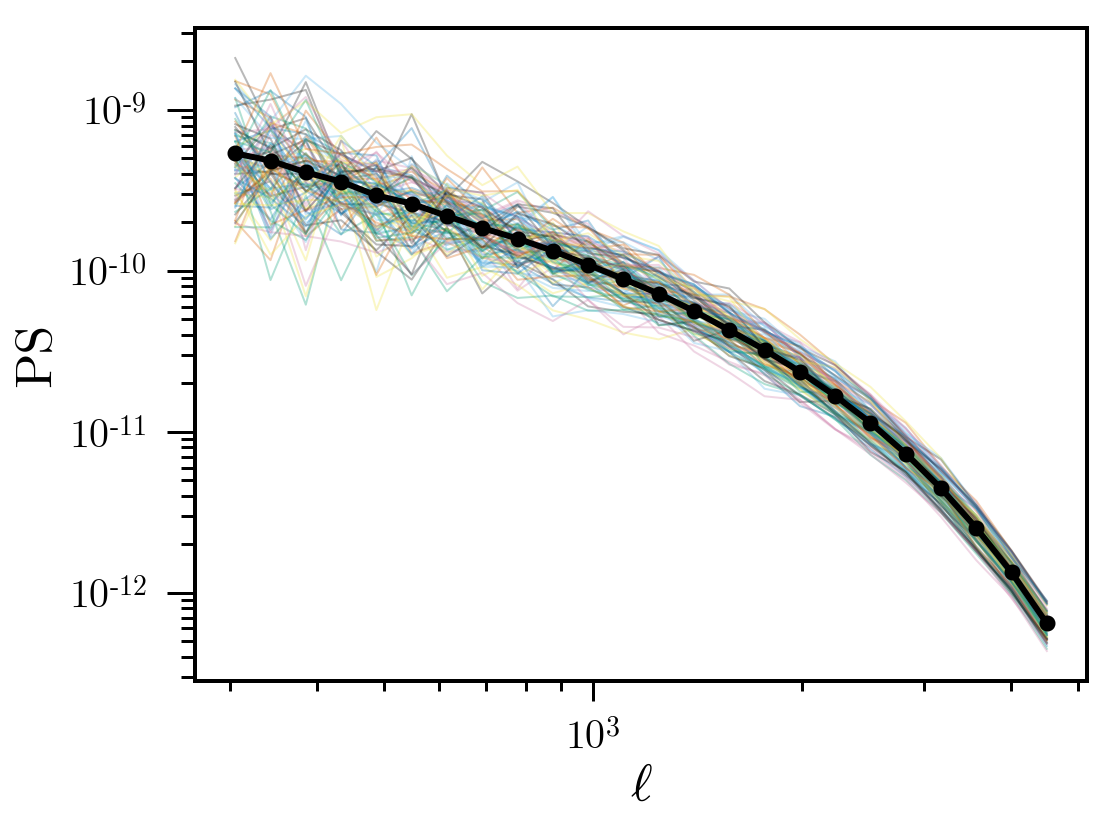

In [5]:
for i in range(100):
    plt.plot(ell, ps_mean[0][i,:], alpha=0.3, lw=1.0 )

plt.plot(  ell, np.mean(ps_mean[0], axis=0) , 'k.-', markersize=10)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel('PS')

In [6]:
ell[10]

983.8553703403264

Text(0,0.5,'Counts')

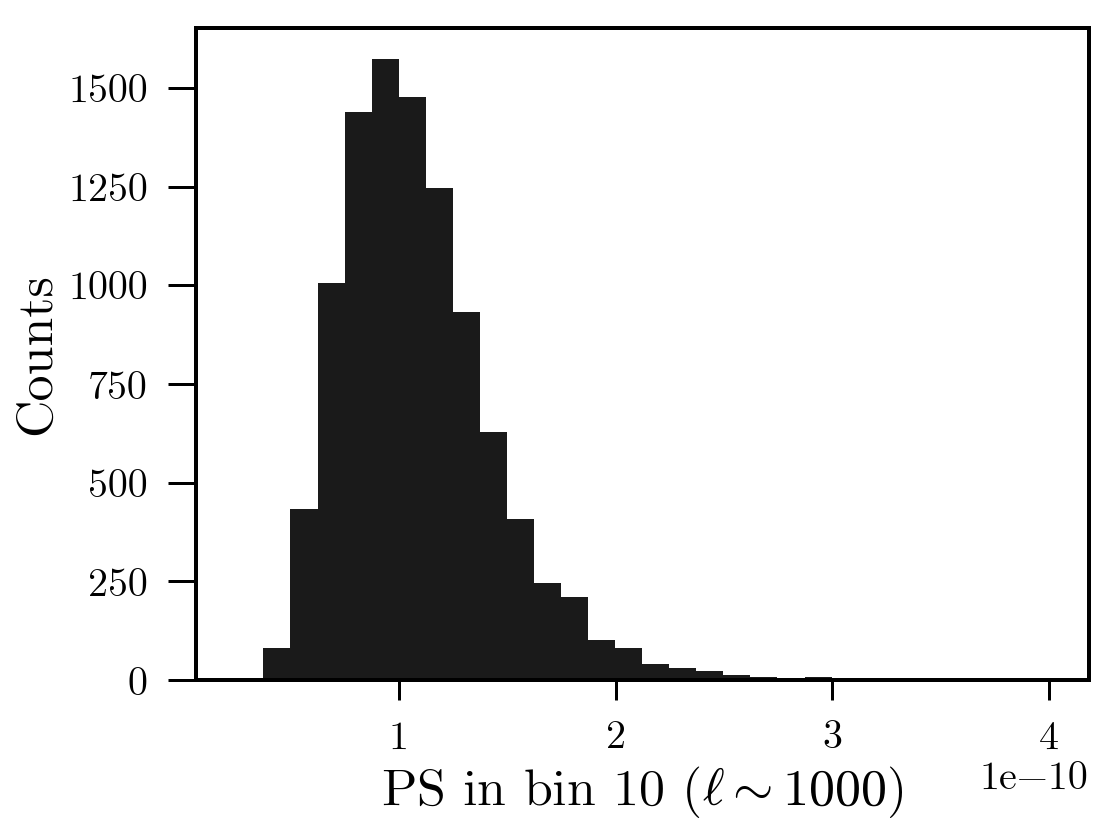

In [7]:
test_ell_bin = 10
plt.hist( (ps_mean[0][:,test_ell_bin]), bins=30)
plt.xlabel('PS in bin 10 ($\ell \sim 1000$)')
plt.ylabel('Counts')

Text(0,0.5,'Counts')

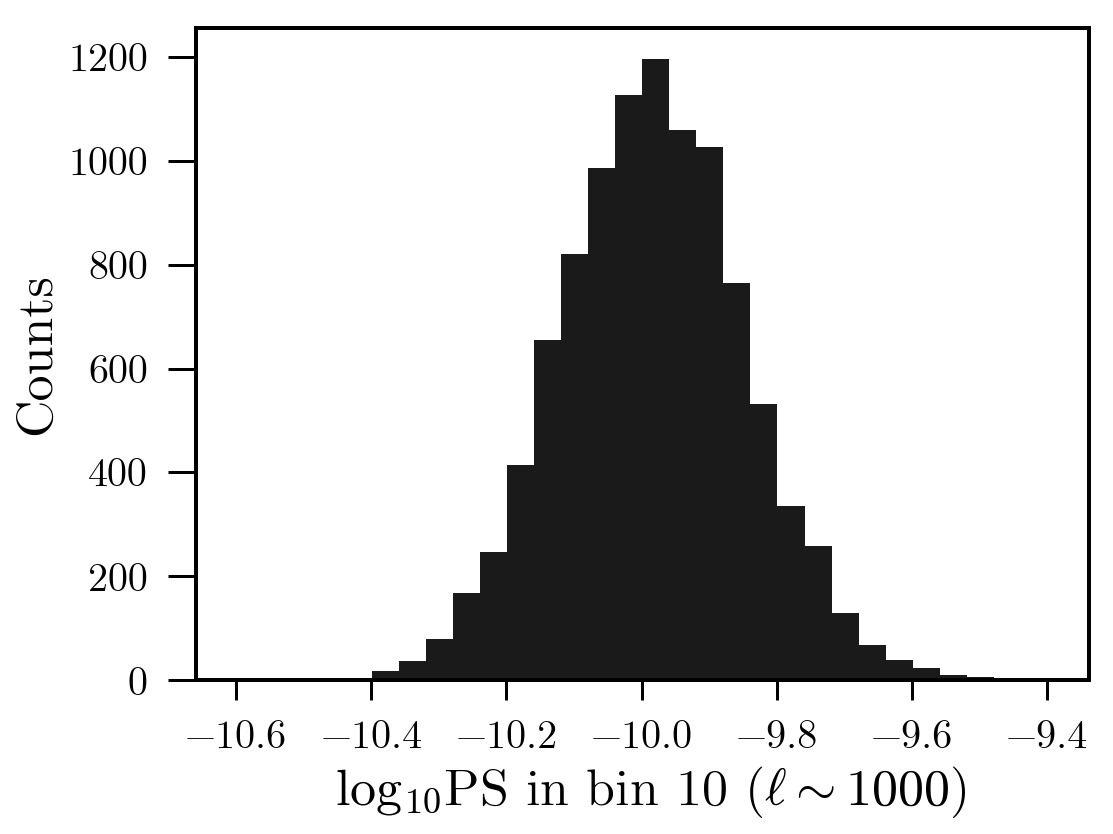

In [96]:

plt.hist( np.log10(ps_mean[0][:,test_ell_bin]), bins=30)
plt.xlabel(' $\log_{10}$PS in bin 10 ($\ell \sim 1000$)')
plt.ylabel('Counts')

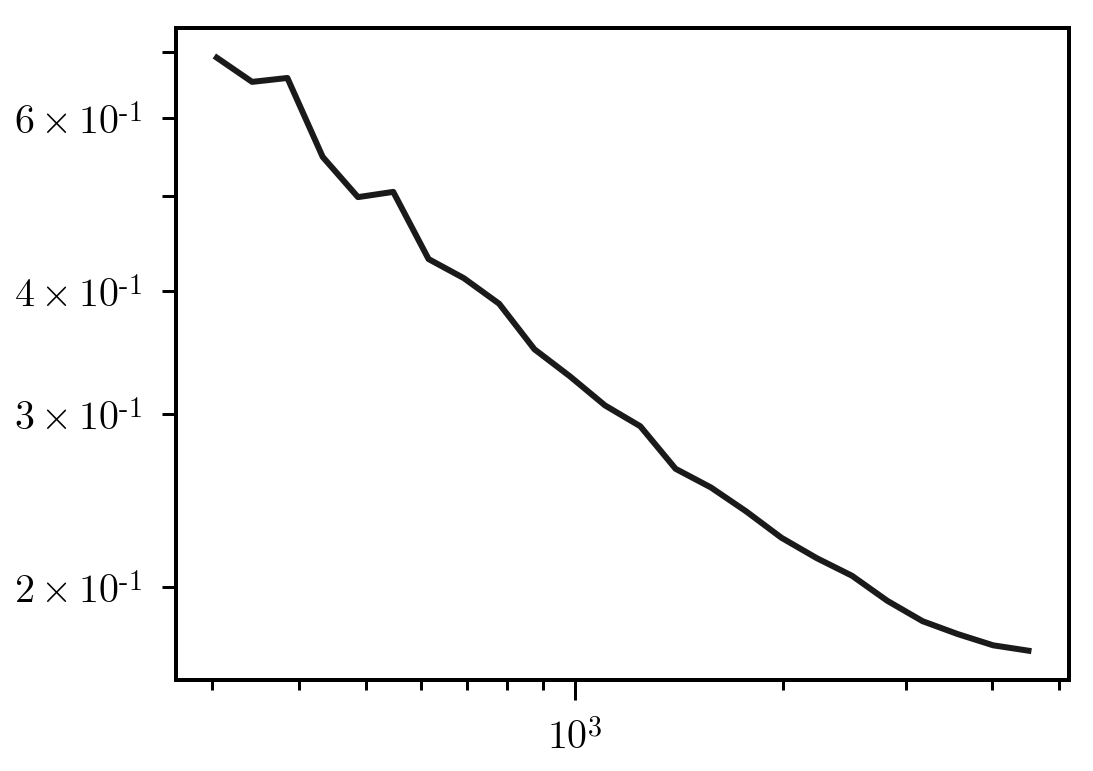

In [97]:
plt.plot( ell, np.std( ps_mean[0], axis=0 ) / np.mean( ps_mean[0], axis=0 ) )
plt.yscale('log')
plt.xscale('log')

# Normalized

# Not Normalized

In [102]:

X = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
X = np.atleast_2d(X).T
y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean])
dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean])
PS_scale = np.mean(y)
y /= PS_scale
dy /= PS_scale

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


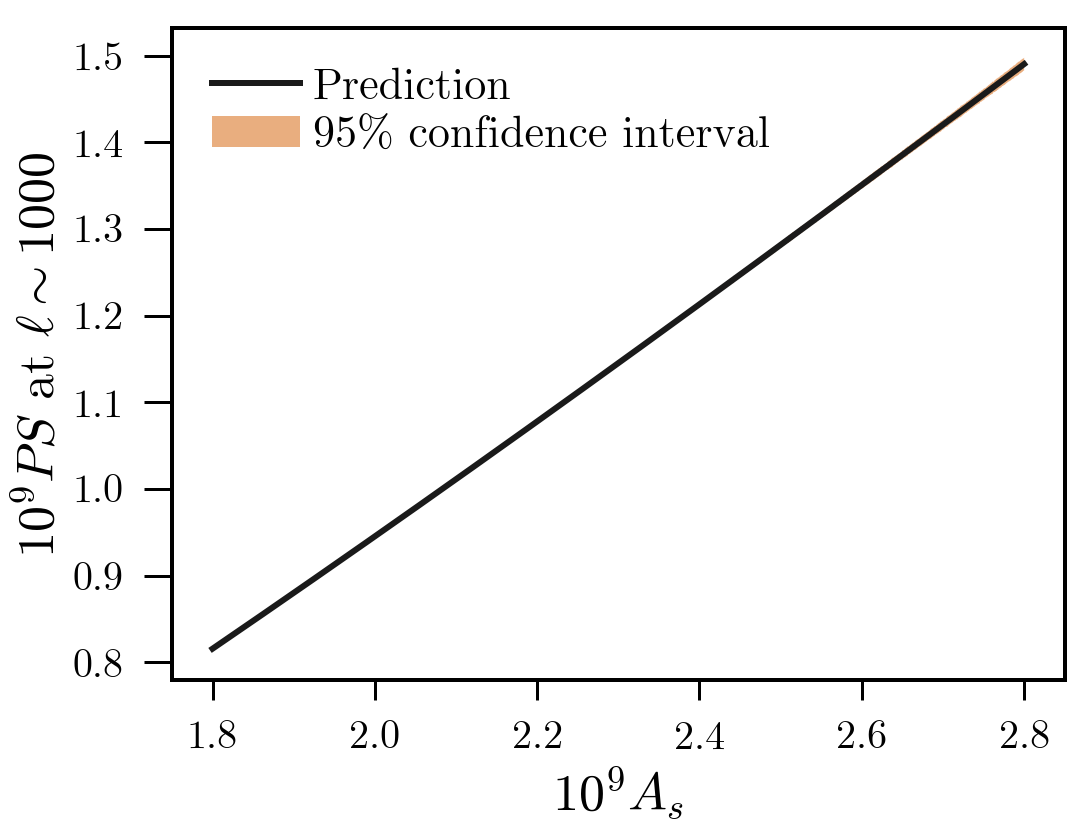

In [103]:
kernel =  C( 1.0, (1e-3, 1e2))  * RBF( [0.1,0.2,0.1], (1e-3, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy) ** 2, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

As_grid = np.linspace( 1.8, 2.8, 1000)
x = [ [0.1, 0.3, As_temp] for As_temp in As_grid ]
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
# plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(As_grid, y_pred, '-', label=u'Prediction')
plt.fill(np.concatenate([As_grid, As_grid[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc=default_color_list[3], ec='None', label='95% confidence interval')
plt.xlabel('$10^9 A_s$')
plt.ylabel('$10^9 PS$ at $\ell \sim 1000$')
# plt.ylim(-10, 20)
plt.legend(loc='upper left')

# Building an Emulator

In [106]:
def build_GP_normed( params, ell, ps_mean,
             mnu_scale = 2.0, omegam_scale = 0.02, As_scale = 5.0, 
             PS_scale = 1e-9 ):

    scale_vec = np.array([mnu_scale,omegam_scale,As_scale])

    gp_list = []
    for test_ell_bin in range(len(ell)):
        X = np.array([table['M_nu(eV)'] / mnu_scale, 
                      table['Omega_m'] / omegam_scale, 
                      table['10^9*A_s'] / As_scale])
        X = np.atleast_2d(X).T
        y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
        dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
        kernel =  C( 1.0, (1e-3, 1e3))  * RBF( 1.0, (1e-5, 1e5))
        gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy/y) ** 2, n_restarts_optimizer=10)
        gp.fit(X, y)
        gp_list.append(gp)

    def get_PS_( x ):
        y_pred_list = []
        sigma_list = []
        for gp in gp_list:
            y_pred, sigma = gp.predict( np.atleast_2d(x)/scale_vec, return_std=True)
            y_pred_list.append(y_pred[0])
            sigma_list.append(sigma[0])

        return y_pred_list, sigma_list
    
    return get_PS_


def build_GP( params, ell, ps_mean,
             mnu_scale = 0.12, omegam_scale = 0.045, As_scale = 0.3, 
             PS_scale = 1e-9 ):

    scale_vec = np.array([mnu_scale,omegam_scale,As_scale])

    gp_list = []
    for test_ell_bin in range(len(ell)):
        X = np.array([table['M_nu(eV)'] / mnu_scale, 
                      table['Omega_m'] / omegam_scale, 
                      table['10^9*A_s'] / As_scale])
        X = np.atleast_2d(X).T
        y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
        dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
        kernel =  C( 1.0, (1e-3, 1e3))  * RBF( 1.0, (1e-5, 1e5))
        gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy) ** 2, n_restarts_optimizer=10)
        gp.fit(X, y)
        gp_list.append(gp)

    def get_PS_( x ):
        y_pred_list = []
        sigma_list = []
        for gp in gp_list:
            y_pred, sigma = gp.predict( np.atleast_2d(x)/scale_vec, return_std=True)
            y_pred_list.append(y_pred[0])
            sigma_list.append(sigma[0])

        return y_pred_list, sigma_list
    
    return get_PS_

In [35]:
print('not normed')
params_ = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell_, ps_mean_ = get_real_list( 'PS', noisy='KN', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
get_PS = build_GP( params_, ell_, ps_mean_ )

print('normed')
params_ = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell_, ps_mean_ = get_real_list( 'PS', noisy='KN', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
get_PS_normed = build_GP_normed( params_, ell_, ps_mean_ )

not normed
normed


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.61085258e-05, -8.23549996e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 14, 'warnflag': 2}
  " state: %s" % convergence_dict)


not normed
normed


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Text(0.5,0,'$\\ell$')

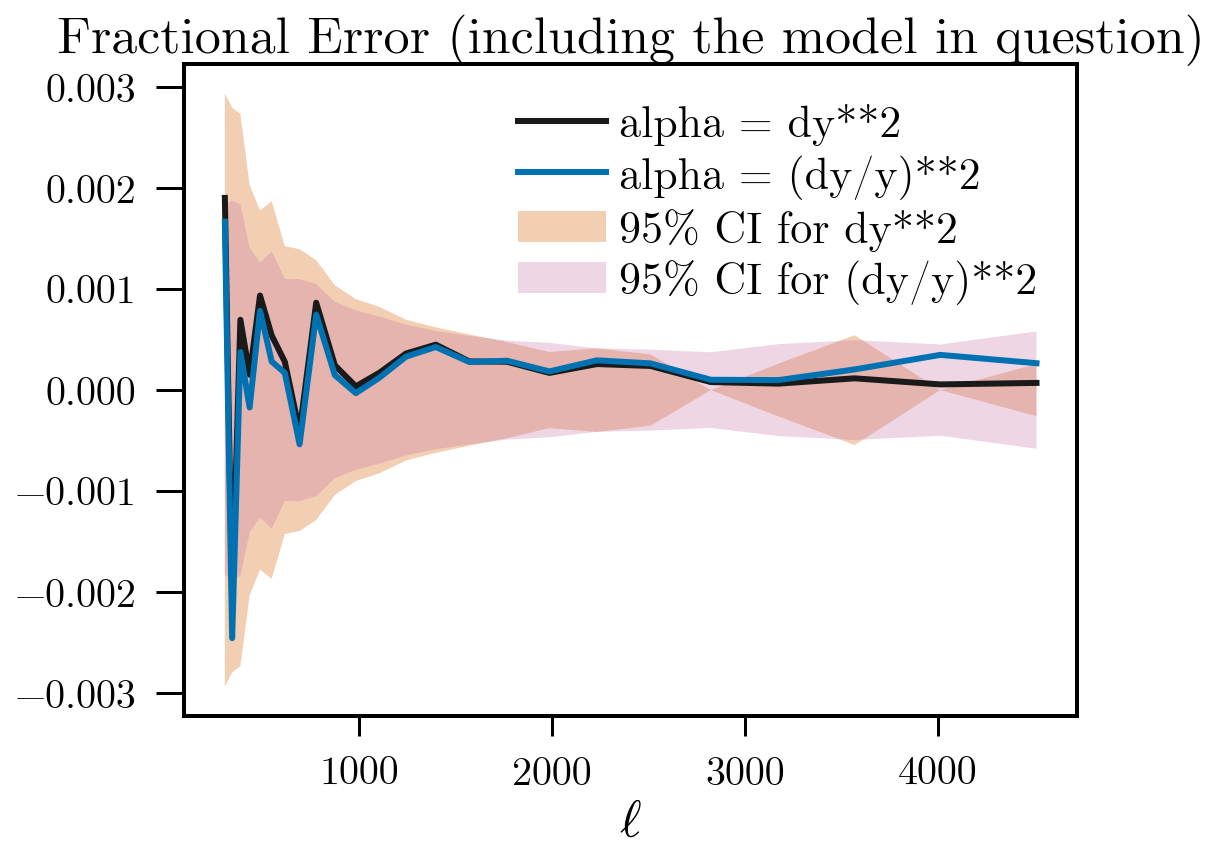

In [36]:
print('not normed')
test_parameter_index = 20
ys, sigs = get_PS( params_.T[test_parameter_index] )
ys = 1e-9 * np.array(ys)
sigs = 1e-9 * np.array(sigs)
# plt.plot( ell, ys )
plt.fill(np.concatenate([ell_, ell_[::-1]]),
         np.concatenate([- 1.9600 * sigs/ys ,
                        ( 1.9600 * sigs/ys)[::-1]]),
         alpha=.3, fc=default_color_list[3], ec='None', label='95% CI for dy**2')

real_ps = np.mean(ps_mean_[test_parameter_index],axis=0)
plt.plot(  ell_, (ys-real_ps)/real_ps, label='alpha = dy**2' )


print('normed')
ys, sigs = get_PS_normed( params_.T[test_parameter_index] )
ys = 1e-9 * np.array(ys)
sigs = 1e-9 * np.array(sigs)
# plt.plot( ell, ys )
plt.fill(np.concatenate([ell_, ell_[::-1]]),
         np.concatenate([- 1.9600 * sigs/ys ,
                        ( 1.9600 * sigs/ys)[::-1]]),
         alpha=.3, fc=default_color_list[4], ec='None', label='95% CI for (dy/y)**2')

real_ps = np.mean(ps_mean_[test_parameter_index],axis=0)
plt.plot(  ell_, (ys-real_ps)/real_ps, label='alpha = (dy/y)**2' )

plt.legend()
plt.title('Fractional Error (including the model in question)')
plt.xlabel(r'$\ell$')

# Removing Elements for Testing

In [39]:
test_parameter_index = 1

params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='K', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.delete(params, test_parameter_index, 1)
del ps_mean[test_parameter_index]

mnu_scale = 0.12
omegam_scale = 0.045
As_scale = 0.3
PS_scale = 1e-9
scale_vec = np.array([mnu_scale,omegam_scale,As_scale])

gp_list = []
print(params.shape)
for test_ell_bin in range(len(ell)):
    X = np.array([ params[0] / mnu_scale, 
                   params[1] / omegam_scale, 
                   params[2] / As_scale])
    X = np.atleast_2d(X).T
    y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
    dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
    kernel =  C( 1.0, (1e-3, 1e3))  * RBF( 1.0, (1e-5, 1e5))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy) ** 2, n_restarts_optimizer=10)
    gp.fit(X, y)
    gp_list.append(gp)
    
def get_PS( x ):
    y_pred_list = []
    sigma_list = []
    for gp in gp_list:
        y_pred, sigma = gp.predict( np.atleast_2d(x)/scale_vec, return_std=True)
        y_pred_list.append(y_pred[0])
        sigma_list.append(sigma[0])
    
    return y_pred_list, sigma_list

(3, 100)


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.0003457 , -0.00226664]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 11, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00055294, -0.00367463]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.64827118e-04, -9.36056167e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 15, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/si

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


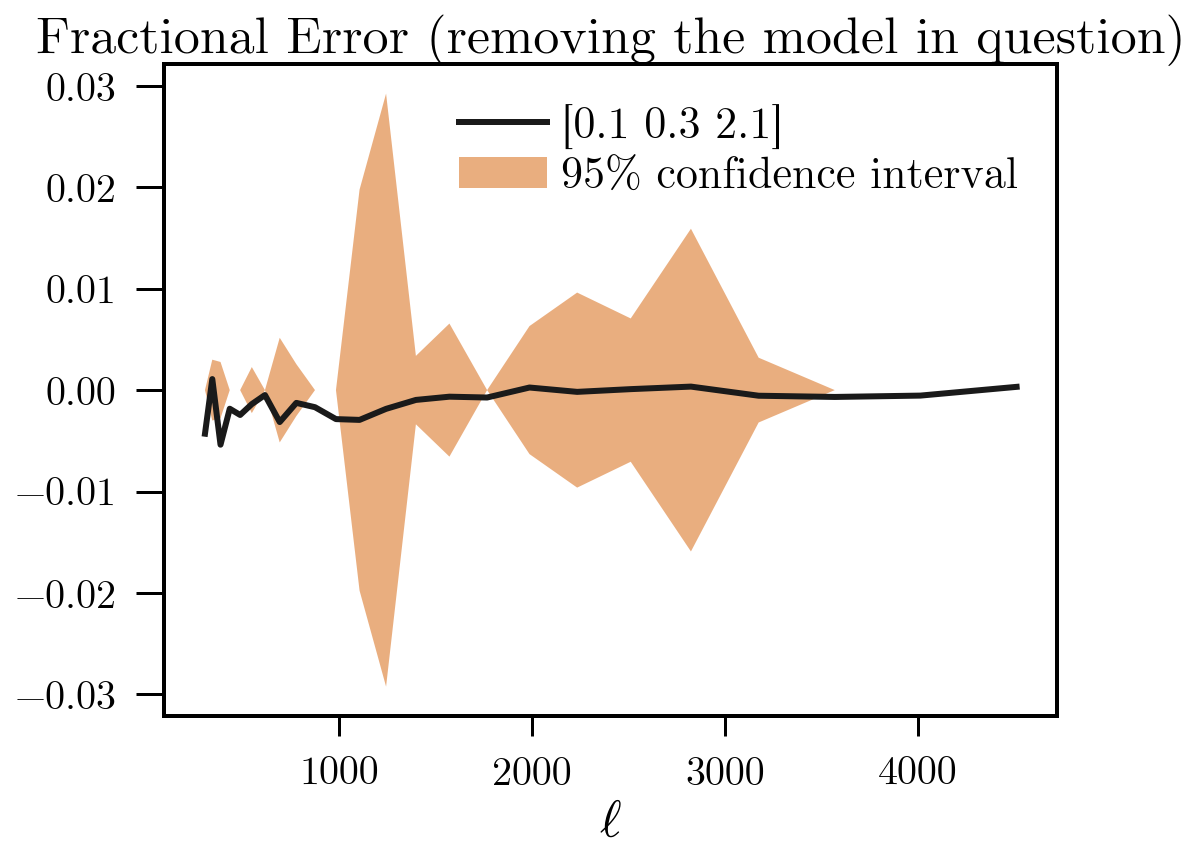

In [40]:
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='K', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )


ys, sigs = get_PS( params.T[test_parameter_index] )
ys = 1e-9 * np.array(ys)
sigs = 1e-9 * np.array(sigs)

# plt.plot( ell, ys )
plt.fill(np.concatenate([ell, ell[::-1]]),
         np.concatenate([- 1.9600 * sigs/ys ,
                        ( 1.9600 * sigs/ys)[::-1]]),
         alpha=.5, fc=default_color_list[3], ec='None', label='95% confidence interval')

real_ps = np.mean(ps_mean[test_parameter_index],axis=0)
plt.plot(  ell, (ys-real_ps)/real_ps, label=str(params.T[test_parameter_index]) )
plt.title('Fractional Error (removing the model in question)')
plt.xlabel(r'$\ell$')
plt.legend()

# Reconstruction Accuracy
We want to compare several situations,
1. fiducial settings (`normalize_y=True`, hyperparameters are 3 lengths and 1 amplitude, normalized PS, errors are set to standard error for each bin, scaled PS)
2. `normalize_y=False`
3. `alpha=0`
4. fixed hyperparameters
5. RBF

In [83]:
test_parameter_index = 1

## 1. fiducial

In [134]:
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='K', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.delete(params, test_parameter_index, 1)
del ps_mean[test_parameter_index]

mnu_scale = 2.0
omegam_scale = 0.2
As_scale = 5.0
scale_vec = np.array([mnu_scale,omegam_scale,As_scale])

gp_list = []
print(params.shape)

PS_scale = []
for test_ell_bin in range(len(ell)):
    X = np.array([ params[0] / mnu_scale, 
                   params[1] / omegam_scale, 
                   params[2] / As_scale])
    X = np.atleast_2d(X).T
    y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean])
    dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean])
    PS_scale.append(np.mean(y))
    y /= PS_scale[-1]
    dy /= PS_scale[-1]
    kernel = C( 10.0, (1e-3,1e3)) * RBF( np.ones(3), (1e-5, 1e5))
    gp = GaussianProcessRegressor(kernel=kernel, 
                                  n_restarts_optimizer=10,
                                  normalize_y=True)
    gp.fit(X, y)
    gp_list.append(gp)

    
PS_scale = np.array(PS_scale)
    
def get_PS( x ):
    y_pred_list = []
    sigma_list = []
    for gp in gp_list:
        y_pred, sigma = gp.predict( np.atleast_2d(x)/scale_vec, return_std=True)
        y_pred_list.append(y_pred[0])
        sigma_list.append(sigma[0])
    
    return y_pred_list, sigma_list

params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='K', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )


ys, sigs = get_PS( params.T[test_parameter_index] )
fid_ys = PS_scale * np.array(ys)
fid_sigs = PS_scale * np.array(sigs)

(3, 100)


In [135]:
for gp in gp_list:
    print(gp.kernel_)

4.5**2 * RBF(length_scale=[1.97, 1.17, 0.554]) + WhiteKernel(noise_level=7.23e-05)
3.2**2 * RBF(length_scale=[1.3, 0.93, 0.68]) + WhiteKernel(noise_level=7.22e-05)
3.69**2 * RBF(length_scale=[1.46, 1.14, 0.646]) + WhiteKernel(noise_level=3.96e-05)
5.14**2 * RBF(length_scale=[1.57, 1.43, 0.651]) + WhiteKernel(noise_level=3.86e-05)
2.48**2 * RBF(length_scale=[0.873, 0.606, 0.774]) + WhiteKernel(noise_level=1.78e-05)
5.13**2 * RBF(length_scale=[1.36, 1.32, 0.845]) + WhiteKernel(noise_level=4.36e-05)
3.47**2 * RBF(length_scale=[0.955, 1, 0.717]) + WhiteKernel(noise_level=2.12e-05)
2.37**2 * RBF(length_scale=[0.842, 0.583, 0.746]) + WhiteKernel(noise_level=1.16e-05)
3.63**2 * RBF(length_scale=[1.23, 1.07, 0.701]) + WhiteKernel(noise_level=3.29e-05)
2.84**2 * RBF(length_scale=[0.957, 0.597, 0.979]) + WhiteKernel(noise_level=1e-05)
2.09**2 * RBF(length_scale=[0.884, 0.58, 0.756]) + WhiteKernel(noise_level=1.02e-05)
3.05**2 * RBF(length_scale=[0.897, 0.687, 1.02]) + WhiteKernel(noise_level=1e-

## 2. normalize_y = False

In [63]:
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='KN', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.delete(params, test_parameter_index, 1)
del ps_mean[test_parameter_index]

gp_list = []
print(params.shape)
for test_ell_bin in range(len(ell)):
    X = np.array([ params[0] / mnu_scale, 
                   params[1] / omegam_scale, 
                   params[2] / As_scale])
    X = np.atleast_2d(X).T
    y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
    dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
    kernel =  C( 1.0, (1e-3, 1e3))  * RBF( np.ones(3), (1e-5, 1e5))
    gp = GaussianProcessRegressor(kernel=kernel, 
                                  alpha=(dy)**2, 
                                  n_restarts_optimizer=10,
                                  normalize_y=False)
    gp.fit(X, y)
    gp_list.append(gp)
    
def get_PS( x ):
    y_pred_list = []
    sigma_list = []
    for gp in gp_list:
        y_pred, sigma = gp.predict( np.atleast_2d(x)/scale_vec, return_std=True)
        y_pred_list.append(y_pred[0])
        sigma_list.append(sigma[0])
    
    return y_pred_list, sigma_list

params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='KN', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )


ys, sigs = get_PS( params.T[test_parameter_index] )
normyfalse_ys = 1e-9 * np.array(ys)
normyfalse_sigs = 1e-9 * np.array(sigs)

(3, 100)


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


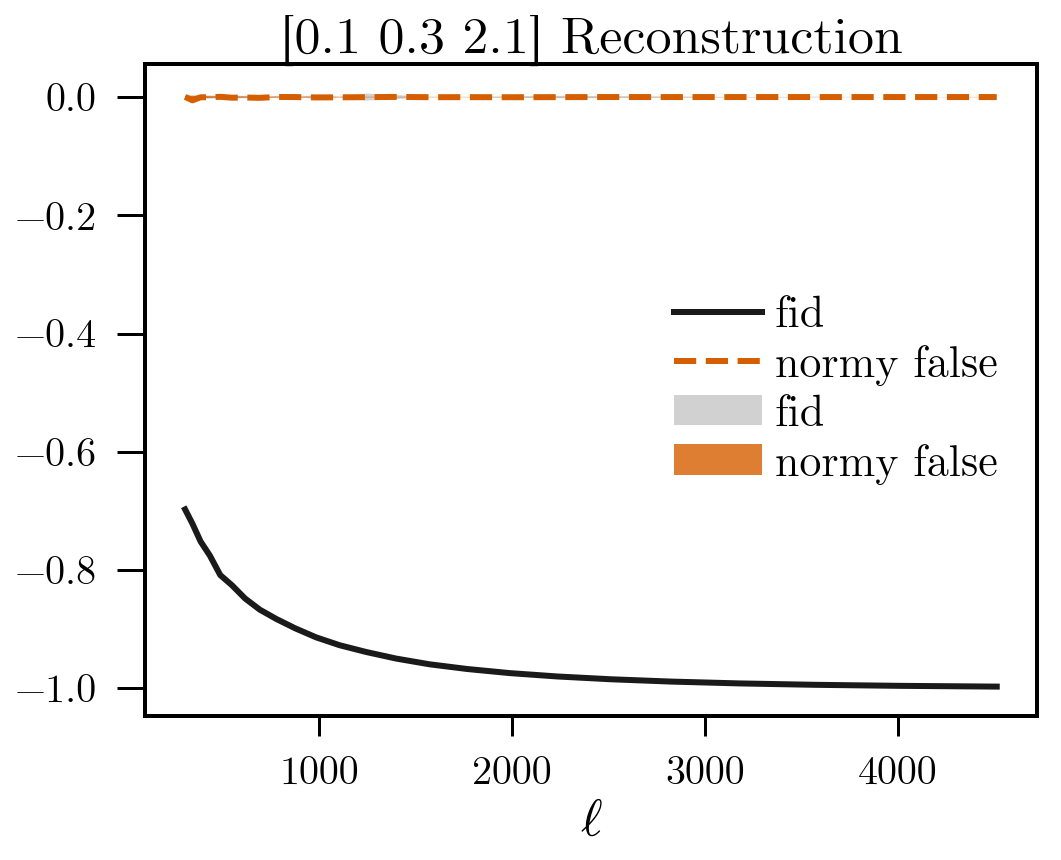

In [64]:

plt.fill(np.concatenate([ell, ell[::-1]]),
         np.concatenate([- 1.9600 * fid_sigs/fid_ys ,
                        ( 1.9600 * fid_sigs/fid_ys)[::-1]]),
         alpha=.2, fc=default_color_list[0], ec='None', label='fid')

plt.fill(np.concatenate([ell, ell[::-1]]),
         np.concatenate([- 1.9600 * normyfalse_sigs/normyfalse_ys ,
                        ( 1.9600 * normyfalse_sigs/normyfalse_ys)[::-1]]),
         alpha=.8, fc=default_color_list[3], ec='None', label='normy false')

real_ps = np.mean(ps_mean[test_parameter_index],axis=0)
plt.title(str(params.T[test_parameter_index]))
plt.plot(  ell, (fid_ys-real_ps)/real_ps, label='fid' )
plt.plot(  ell, (normyfalse_ys-real_ps)/real_ps, color=default_color_list[3],ls='--', label='normy false' )

plt.title(str(params.T[test_parameter_index]) + ' Reconstruction')
plt.xlabel(r'$\ell$')
plt.legend()

## 3. alpha=0

In [123]:
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='KN', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.delete(params, test_parameter_index, 1)
del ps_mean[test_parameter_index]


gp_list = []
print(params.shape)
for test_ell_bin in range(len(ell)):
    X = np.array([ params[0] / mnu_scale, 
                   params[1] / omegam_scale, 
                   params[2] / As_scale])
    X = np.atleast_2d(X).T
    y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
    dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
    kernel =  C( 1.0, (1e-3, 1e3))  * RBF( np.ones(3), (1e-5, 1e5))
    gp = GaussianProcessRegressor(kernel=kernel,
                                  n_restarts_optimizer=10,
                                  normalize_y=True)
    gp.fit(X, y)
    gp_list.append(gp)
    
def get_PS( x ):
    y_pred_list = []
    sigma_list = []
    for gp in gp_list:
        y_pred, sigma = gp.predict( np.atleast_2d(x)/scale_vec, return_std=True)
        y_pred_list.append(y_pred[0])
        sigma_list.append(sigma[0])
    
    return y_pred_list, sigma_list

params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='KN', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )


ys, sigs = get_PS( params.T[test_parameter_index] )
noalpha_ys = 1e-9 * np.array(ys)
noalpha_sigs = 1e-9 * np.array(sigs)

(3, 100)


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


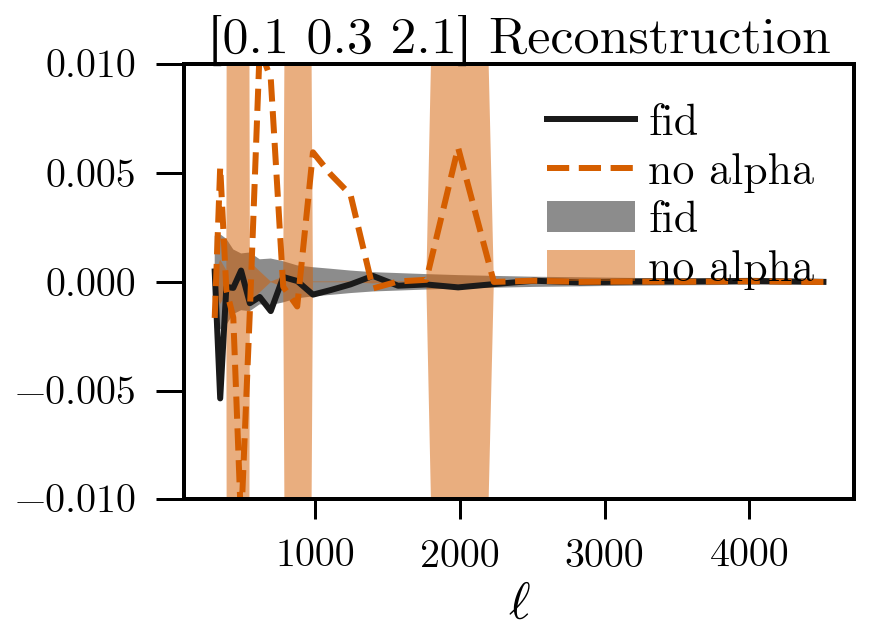

In [133]:

plt.fill(np.concatenate([ell, ell[::-1]]),
         np.concatenate([- 1.9600 * fid_sigs/fid_ys ,
                        ( 1.9600 * fid_sigs/fid_ys)[::-1]]),
         alpha=.5, fc=default_color_list[0], ec='None', label='fid')

plt.fill(np.concatenate([ell, ell[::-1]]),
         np.concatenate([- 1.9600 * noalpha_sigs/normyfalse_ys ,
                        ( 1.9600 * noalpha_sigs/normyfalse_ys)[::-1]]),
         alpha=.5, fc=default_color_list[3], ec='None', 
         label='no alpha')

real_ps = np.mean(ps_mean[test_parameter_index],axis=0)
plt.title(str(params.T[test_parameter_index]))
plt.plot(  ell, (fid_ys-real_ps)/real_ps, label='fid' )
plt.plot(  ell, (noalpha_ys-real_ps)/real_ps, color=default_color_list[3],ls='--', 
         label='no alpha' )

plt.title(str(params.T[test_parameter_index]) + ' Reconstruction')
plt.xlabel(r'$\ell$')
plt.ylim(-0.01,0.01)
plt.legend()

In [151]:
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='KN', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.delete(params, test_parameter_index, 1)
del ps_mean[test_parameter_index]

mnu_scale = 1
omegam_scale = 1
As_scale = 1
PS_scale = 1e-9
scale_vec = np.array([mnu_scale,omegam_scale,As_scale])

gp_list = []
print(params.shape)
for test_ell_bin in range(len(ell)):
    X = np.array([ params[0] / mnu_scale, 
                   params[1] / omegam_scale, 
                   params[2] / As_scale])
    X = np.atleast_2d(X).T
    y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
    dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
    kernel = None
    gp = GaussianProcessRegressor(kernel=kernel, 
                                  alpha=(dy)**2, 
                                  n_restarts_optimizer=10,
                                  normalize_y=True)
    gp.fit(X, y)
    gp_list.append(gp)
    
def get_PS( x ):
    y_pred_list = []
    sigma_list = []
    for gp in gp_list:
        y_pred, sigma = gp.predict( np.atleast_2d(x)/scale_vec, return_std=True)
        y_pred_list.append(y_pred[0])
        sigma_list.append(sigma[0])
    
    return y_pred_list, sigma_list

params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
ell, ps_mean = get_real_list( 'PS', noisy='KN', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )


ys, sigs = get_PS( params.T[test_parameter_index] )
fixed_hyper_ys = 1e-9 * np.array(ys)
fixed_hyper_sigs = 1e-9 * np.array(sigs)

(3, 100)


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


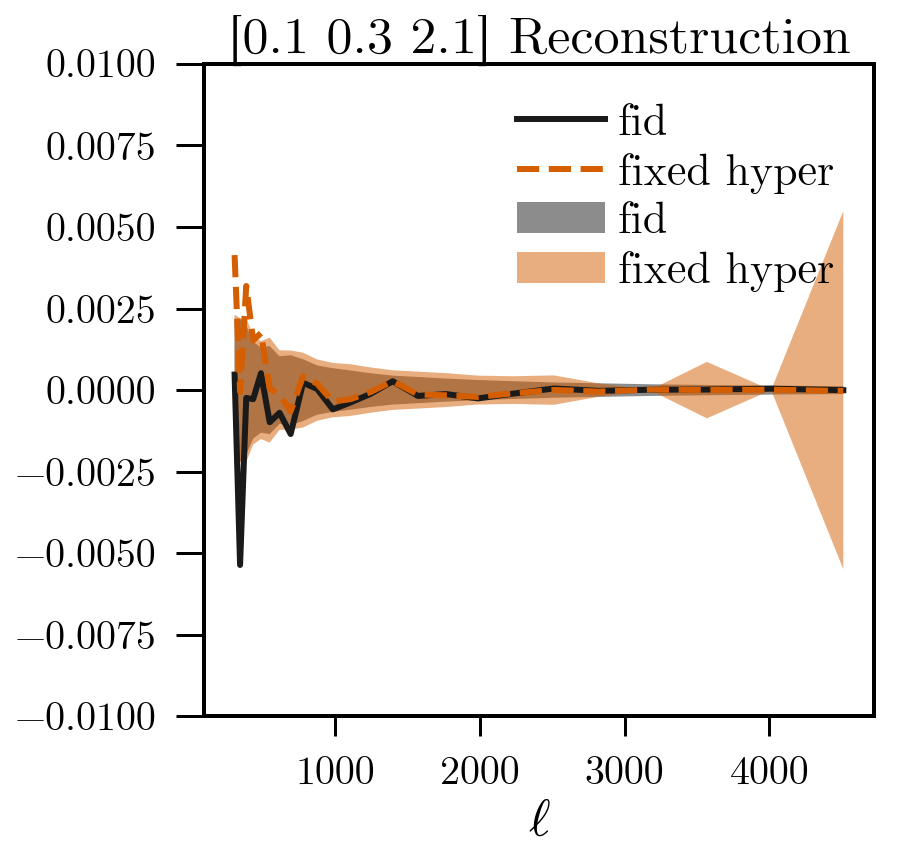

In [152]:
plt.figure(figsize=(6,6))
plt.fill(np.concatenate([ell, ell[::-1]]),
         np.concatenate([- 1.9600 * fid_sigs/fid_ys ,
                        ( 1.9600 * fid_sigs/fid_ys)[::-1]]),
         alpha=.5, fc=default_color_list[0], ec='None', label='fid')

plt.fill(np.concatenate([ell, ell[::-1]]),
         np.concatenate([- 1.9600 * fixed_hyper_sigs/fixed_hyper_ys ,
                        ( 1.9600 * fixed_hyper_sigs/fixed_hyper_ys)[::-1]]),
         alpha=.5, fc=default_color_list[3], ec='None', 
         label='fixed hyper')

real_ps = np.mean(ps_mean[test_parameter_index],axis=0)
plt.title(str(params.T[test_parameter_index]))
plt.plot(  ell, (fid_ys-real_ps)/real_ps, label='fid' )
plt.plot(  ell, (fixed_hyper_ys-real_ps)/real_ps, color=default_color_list[3],ls='--', 
         label='fixed hyper' )

plt.title(str(params.T[test_parameter_index]) + ' Reconstruction')
plt.xlabel(r'$\ell$')
plt.ylim(-0.01,0.01)
plt.legend()

# Comparison to RBF

In [114]:
ell, ps_mean = get_meanstack_multiz( 'PS', noisy='K', redshifts=['05'],  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])

# remove the 1st row (fiducial B)
ps_mean = np.delete(ps_mean, 1, axis=0)
params = np.delete(params, 1, axis=1)
invcov = get_invcov( 'PS', noisy='K', redshifts=['05'], 
                                   bin_min=300, bin_max=5000, smoothing='1.00', binscale='log')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0


nr 9999 nb 24 bin 0.99749949989998 sky 0.001225


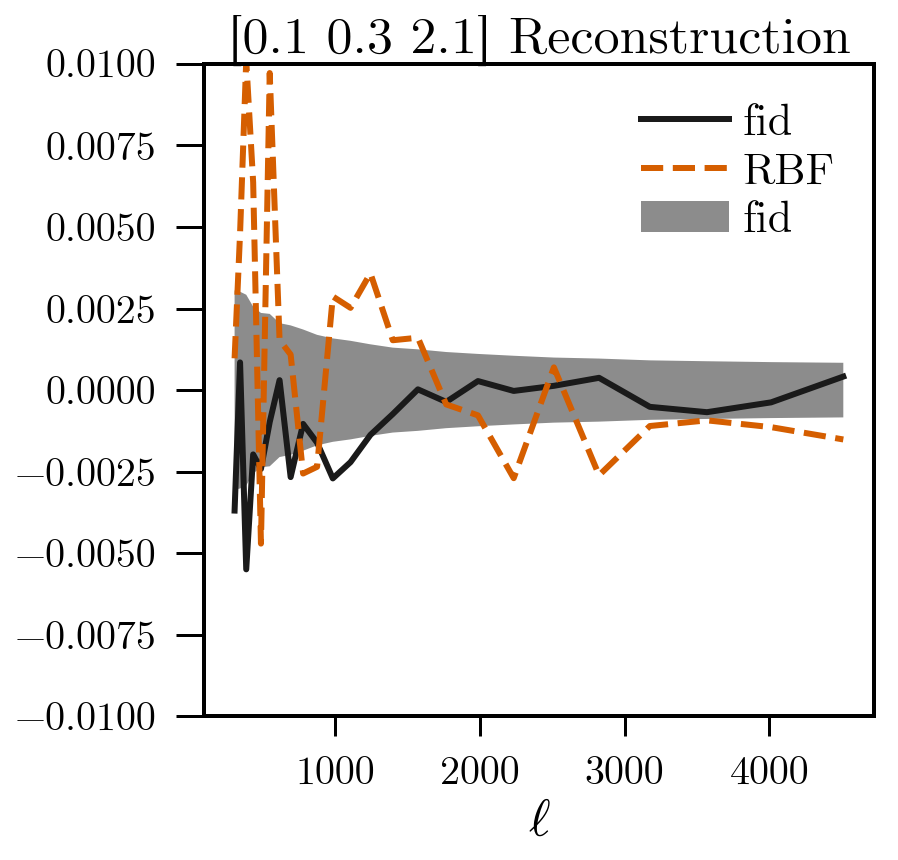

In [120]:
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])
rbf_y = test_interp_ps.interp_func( params.T[test_parameter_index] )


ell, ps_mean = get_real_list( 'PS', noisy='K', redshift='05',  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )



plt.figure(figsize=(6,6))
plt.fill(np.concatenate([ell, ell[::-1]]),
         np.concatenate([- 1.9600 * fid_sigs/fid_ys ,
                        ( 1.9600 * fid_sigs/fid_ys)[::-1]]),
         alpha=.5, fc=default_color_list[0], ec='None', label='fid')
real_ps = np.mean(ps_mean[test_parameter_index],axis=0)
plt.title(str(params.T[test_parameter_index]))
plt.plot(  ell, (fid_ys-real_ps)/real_ps, label='fid' )
plt.plot(  ell, (rbf_y-real_ps)/real_ps, color=default_color_list[3],ls='--', 
         label='RBF' )

plt.title(str(params.T[test_parameter_index]) + ' Reconstruction')
plt.xlabel(r'$\ell$')
plt.ylim(-0.01,0.01)
plt.legend()

Text(0.5,1,'| (residual RBF) / (residual GP)|')

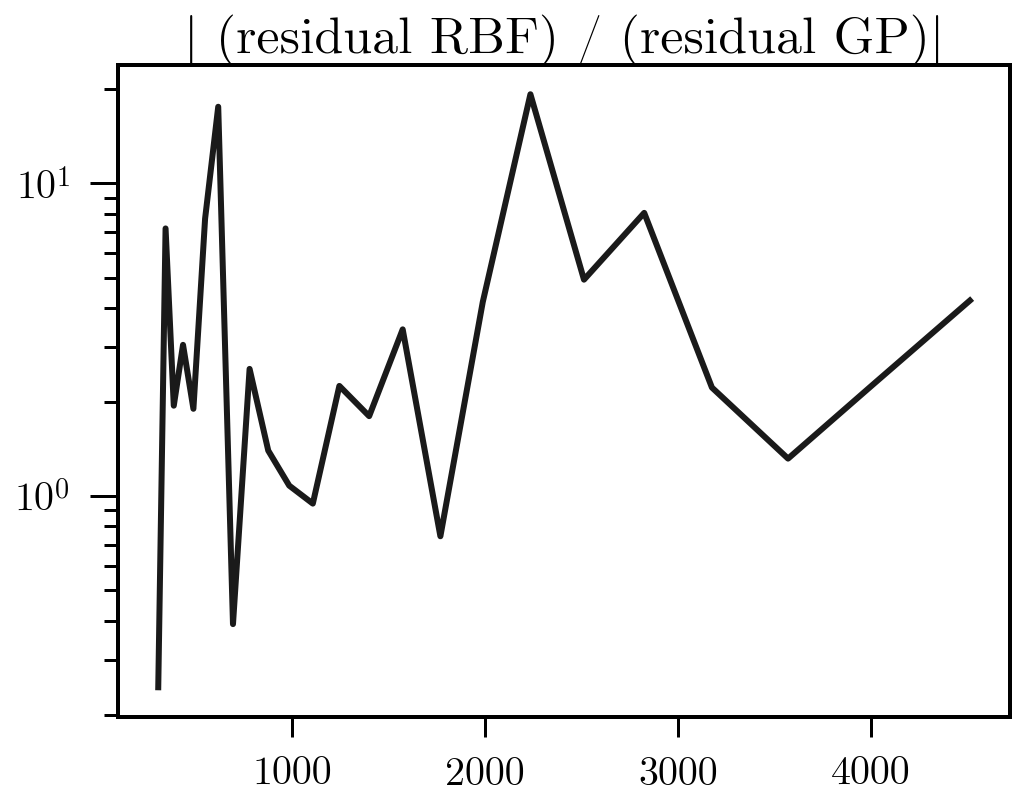

In [116]:
plt.plot( ell, np.abs( (rbf_y-real_ps) / (fid_ys-real_ps) ) )
plt.yscale('log')
plt.title('| (residual RBF) / (residual GP)|')